# Furniture classification

## Transfer-learning evaluation

This notebook uses the transfer learning based trained model to classify the furniture using images from internet.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import utilities.training as training
import utilities.visuals  as visuals
import utilities.data     as data

Using TensorFlow backend.


### Recap class names

In [4]:
class_names = ['cup', 'desk', 'pillow', 'mug', 'table lamp']

### Transfer learning-approach classifier re-initialization

This notebook aims to re-initilize the classifier for testing/evalutation purposes.

In [8]:
def get_model(num_classes, input_shape):
    from keras.layers import Dropout, Dense
    from keras.models import Sequential, Input
    from keras import regularizers
    from keras import initializers
    import keras.backend as K
    K.set_learning_phase(0)

    classifier = Sequential()
    
    classifier.add(Dense(128, input_shape=input_shape, activation='relu',
                         kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev=0.01, seed=None)))
    
    classifier.add(Dropout(.3))
    
    classifier.add(Dense(num_classes, activation='softmax',
                         kernel_regularizer=regularizers.l2(0.01),
                         activity_regularizer=regularizers.l1(0.01)))
    return classifier

In [9]:
classifier = get_model(5, input_shape=(2048,))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 262,917.0
Trainable params: 262,917.0
Non-trainable params: 0.0
_________________________________________________________________


## Evaluating the model

In [11]:
from utilities.transfer_learning import generate_bottleneck_features

In [12]:
def plot_figures(figures, titles, nrows=1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """
    import cv2
    import matplotlib.pyplot as plt
    fig, axeslist = plt.subplots(figsize=(16, 8), ncols=ncols, nrows=nrows)
    for ind, file_path in enumerate(figures):
        img = cv2.imread(file_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axeslist.ravel()[ind].imshow(cv_rgb, cmap=plt.gray())
        axeslist.ravel()[ind].set_title(titles[ind], fontsize=20)
        # => axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # Optional

In [13]:
class PretrainedFriendlyClassifier(object):
    """Provides friendly classification methods from a base model"""
    def __init__(self, name, model):
        import tensorflow as tf
        import keras.backend as K
        self.name  = name
        self.model = model
        self.sess = tf.Session()
        K.set_session(self.sess)
        K.set_learning_phase(0)
        self.model.load_weights('weights.best.{}.hdf5'.format(self.name))

    def __retrieve(self, url):
        import urllib.request
        import random
        import os
        temp = "/tmp/img_to_classify_{}".format(url.__hash__())
        if not os.path.exists(temp):
            urllib.request.urlretrieve(url, temp)
        return temp
        
    def classify_from_urls(self, urls, nrows=1, ncols=1):
        from tqdm import tqdm_notebook
        images, titles = [], []
        for url in tqdm_notebook(urls):
            tempfile = self.__retrieve(url)
            klass = self.classify(tempfile, display=False)
            images.append(tempfile)
            titles.append(klass)
        plot_figures(images, titles, nrows=nrows, ncols=ncols)
        
    def classify_from_url(self, url, display=True):
        return self.classify(self.__retrieve(url), display=display)
        
    def classify(self, image_path, display=True):
        import numpy as np
        import tensorflow as tf
        import keras.backend as K
        features =\
            generate_bottleneck_features([image_path], silent=True)
        K.set_session(self.sess)
        K.set_learning_phase(0)
        y_pred = np.array([
            np.argmax(
                self.model.predict(np.expand_dims(feature, axis=0)))
            for feature in features
        ])
        klass = class_names[y_pred[0]]
        if display:
            visuals.display_image(image_path, klass)
        return klass

### Testing with images from internet

In [14]:
friendly_classifier =\
    PretrainedFriendlyClassifier('resnet', classifier)

In [15]:
urls = [
    'https://images-na.ssl-images-amazon.com/images/I/718jIP3n0BS._SL1500_.jpg',
    'https://ii.worldmarket.com/fcgi-bin/iipsrv.fcgi?FIF=/images/worldmarket/source/51882_XXX_v1.tif&wid=650&cvt=jpeg',
    'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUSExIVFRUVFxcXFxcVFRUVFxcVFxYXFxUXFRUYHSggGBolHRcVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDQ0NFQ8PFS0ZFRkrKysrKysrKysrKzcrKy0rLSstKy0rNys3NystNy0rKysrKystLSsrLSsrLSsrKysrK//AABEIAMABBwMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAACAwEEBQAGB//EAD8QAAIBAgIFCAgEBQQDAAAAAAABAgMRBCEFMUFRcQYSEzJhc5HwIiRygaGxstEUIzTBFUJSkuFDYoKzM8Lx/8QAFwEBAQEBAAAAAAAAAAAAAAAAAAECA//EABsRAQEBAQEBAQEAAAAAAAAAAAABERICMVEh/9oADAMBAAIRAxEAPwDRgPplaA+DMOivyl/SVvZ/dGBhdS4G9ykXqlb2GYOE6q4Eqxfw5dpso0C7SAegkwUSgh0WGmBEKJQ+DM/lg/U5+3S/7YGhAzuWL9Tn7dH/ALYAYeF2GvhzGwxrYaRI1WlSY0r0pDrlZMiGkLiw7gOpk6R/T1u6qfRIGDJ0h+nrd1U+iRR5DRupG7hzB0bqRuYckWr8A0KgNRUHENMCISYDked5RfqId2vrkehgjz/KL9RDu19cwQ3D6i7ApYbUXIgEwQgWAuRxLOCs6LH02VYvMsUmZQjlH+kr92zBwfVXA3uUX6Sv3cvkefwb9FCrGjRLlIp0S3RAchkRaYcQh0WHEXEOBQ6LE6awTr0JUoySk3B3le3oTjLO3s2GveFCRqRjqvMywFSn14tduuP9yyLuHZ6SlWtr1bhE9HUpPJcz2dX9v2Jx+L3+qFJjkNlo2S1NS4ZPwEyi07NNPcyY1pkBkRMGMTAsRZ2kP09buqn0SBpk6Qf5Fbuqn0SKPI6N1I3cOef0a8kb2HZmLV+AxCaY00g4hpARCQDYM89ygfrMe7X1zPQQZ5/lA/WY93H65gh+GZciU8MW4gGCyQWwBZxEmcFZcWWKRUiyxSZlCuUL9Ur93L5Hn8E/RXA3eUD9Ur93L5MwMF1VwFWNKiy5SZSoFumwLMQosCOoNBDUOpIRctUY5X3liX4JkBMg25iixsZbxKDiUXIVfAY5J5SV+JUg94cZbCoOpgIPU+a92tFeWDmtWfD7Mtwls2jFN6zPManqqEU1ry45E6Qf5Fbuqn0M0VO+y/EDEYaE4Si8lKLjeO6Sadtm0nK9Pn+j9SN7DBvkrKH/AI5qaWyS5r9z1P4HKhOGU4uPFZe56mZyxvZVqkxtxFNjUwGoIXFhplDYs8/yg/Ux7uP1zN5M89p1+sru4/VMEWcNqLsWUcPqLkQomyGzrkMAGcdI4DIgyxSKcWWKTMgOUH6Sv3U/pZgYLqrgje06/VK/dT+lnn8F1I8BSNOiy1BlOiy1FgWosOLFQYVwHJ7DRSsZ+DjzpcM/saTRryx6AzrEko0wgI6K2ExRUSNW8XFWGxXgUSpbht7ZgR3BRjYBifgMj8xcdfYMhuAYhid8reO0VHtGRe4BVTRtOWaXN4fbUVKuiprqtS+D+ORqx3jIS8CXzGp6rzsqco5STXFEpnpcmrPP4iKmjactnN7Vl8NRnlrpiQPPadfrK7uP1TPYVdEzWcWpdmpnj+UVKUcSudFr8uNrpq7UpXs9utEsal1YwzLkGUMMy5BhTWzrgNnSYETkcBJnAYyLFMqwLFMyB03+lr91P6WYGC6seBu6Zfq1bup/SzAwL9CPBCkaVFluDKVJlumwLEGTKQuMgZTA19Fwyct+XgXZAYanaEVuWfzYZuOV+oZ1iSYo0y6wXA5Zkx3FEtbfPn7Ba8wYaswoO7AZfK68+f2Ctt8+cwKb2ed4dPtAPWH2i47hlPcAxLaGmLUg0AyMhkWJSDTyAchsGKiw0wHxkdWoxnHmzipReySTXgxcRkWFZdfk1RecLwfY+dHwf3M3EaCrQzS56/26/wC15+Fz1MRsWZyNdV8/k9mr5g8499itH0qq9OCb36pe6SzPI6b0S6ElZ86Euq3r7U+35ksanrWZKRwE2cZaY8GPpyKsWNgyA9LP1et3c/pZ5/AP0I8Dc0k/yKvdz+lmBgH6EeCFI0qTLUJFKlIsQkBZvkN0fT59RLZrfBZ/495UlM39BYXmw5zWcs/+Oz7+Ak2pbkaSRDCkCzo5OSJSzIuSaiOvsJ1M5/E6SKOazOcgWzgG3zv52h3vn53+eAmGaDjK4D+d58+cxqK8JZWGwd0A4NKwuMr3tsDi8kQMQUXn53i0wvPnzsAZHtDjLWKuFcCxFjUyvBjqb2AOiMiKiNiwpsDz/LOr6NOO9yfgkv8A2PQI8fyyxF6sY/0wv75N/skS/GvP15+bOE1KhxzdGWpDKTK/ODjIgbpCX5NX2JfSzz+j5ehHgjbx0vyqnsS+TMLRcJShFRTk7LUrii/CQ+MxuG0PVfWtFdru/Bfc1KOiaa13l8F4IuJsV9EYVVZ2l1Yq77c8l53HrEhGBw6jH0YpXzyVh9jUjn6uhOaJSJNsgOQTiCygooiOZKIkBDZGoJgNATF5hKVnbYRI5gMi7Pz5/wDoyM87Fd528+dhMpAXITz4jVLMpOW3z51eA3pL2fu+37gWoy2BwdrplZ1MhqlqZA9PYTF5WFOe0PU7gOg7j4yKsZZ2LFNgWYjYMr02WIBTkfN9N4bE161SpF04xb9G/Ok+aso3tbOy1H0HGztTk+x/HJHnIxJmtR4qtybxT14iK9mnb97nHuFTIHMXp80uNpXk0km32A4TDupKy973HocLhIwVkuL2vic5GrcVKOjk01PO6s0tVnsbLtDDxhFRjFRitSSsvBDkg0jWMWg5pDiOUSJIIvUK0HqefbkNaMaa7QVUktTfuZrUbMkQZX8RnHXaXFWfihtLS8f5ouPavSXwz+BdRfsC0dQxEJ9WSfz8BriUJbCaO5p0UANjhjRFrADYi2QSRAAs6xJFgBWoOM9gJ0VYB1OV1Zh0ql1bsyEU1n52kxlbIC9CeXAKMrq/nz9ypTlZvcHSnnbZtAuOfw/xcsxepooUpbPPaWKM7oDRpyLMEUqUi9TRFV9KT/LtvaX7/sZKgaGk5ZxXEpJBUJHBpHAfKMJjXTd1709Tsej0dpGFSyTs/wCl61w3oyqeiKa1uUuLt9KQ1YeEM4wV1qetrg3mco3f631EJIz9H49SfNlr2bn/AJNRRNMOUQZx7B0UDNFRTnHMW6RccA1SLiM+VBivwxrdEDKkUZP4Us0K1SOqTa3PMuOmR0YHQx39UfevsWKeIi9v7FXogeiKNGQLM+N1qbQyOJltV/gBbZwmOJXDiMUgJOZ1yUwIaI5oRzAhvPI55EtkNARJ5hOdmBJkMCzTlZ3LNGeZnt6mWYztnwA1sM/PZvNKgzGws8/cbGHIqpj4Xl7kIVBmjXjeT93yB5oFONA4uqJwHzDmk9GNSJsYbVauFuXdHYt35k9ex7+x9pCQNSncqVsoBg4SpzoZ69T9w6lTuwyiEB3RjIQsS9ZpC3EiUQpS1gc+5QE4ANBdIKlUAJAiumQuddANYEmIniBE8SBblIDnWKUsUInjFvCtVYprbcbDHrbl8TzdbS1OOucVxaKdTT9PZJvgpP5ImmPc06yep3DTPny0473jGpfelb5tF7C8pq610ecu2XNfwTQ0x7RHazJwum6ctd4vdL76jQhXT1NFQ2xHNIUw0wBk8iYyyzOsQkwL+CrG/g5HlKMje0bXeQGpKOYPNLCRHMIpSiSM5pIHyslHNAtnNsxBJlfnk84qLVHEcx9j1l6jjo7Hd+D8DGkyniIFR6eWMyFPGq1jxtTp11akl4P5iHHFP/VfgvsXUx7SWNESxy3nkHg8S9dZ+5R+xK0TVfWrTfCy+RUx6ippBb0V62k4rNyXiYa0FfrSm+MpfcdDQNP+le/MLh1blBSX+on7PpPwRVlygT6sJv8A42+di9T0VBfyrwHwwUVsBjF/ideXVpW9qX2RHNxUtsY8E38WzeVDsC6IivPfwyq+tWlwVl8kStAxfWcpe02/mehVI7oQrEp6HprVFD44GK1RRqdAT0IwZn4Vbjvw5pdCd0AwZjoBQ50eq2uBpfhzvwxMFalpOpHX6XwL9DTUf5k48dXiI/CdhDwXYXamNmhi4yzTTLCnc83+AetXT7Mh9KNaOqV+P3LqY3VEvaPr81q5hUcVUXWh4Zlqjjc+pJW2tO3wKmPfYZ3Q6xkaNxi5sVfWrvzsNWMrkUVjiLnAfJ5MW0XpUSFRMY2pKmMjRLSpBKkWRFdUSehRaVIlUTWIpPDohUFuNBUCVhgM/oUT0RorChLClGb0R3RGosIEsIBlKkEqRqrBkrBgZXQk9CaywgawYGOqASoGysEGsF2BGIsMF+GNxYINYEKwVhQ1hD0EcCg1gQPPLCBLBno44FbhiwS3AebWC7BkMB2HpI4JDY4VBHnI6O/2linox7j0EaKGKIGJS0Sy7S0XFazQSJsQJpYeMdSHWOSCSAhM4KxwH//Z',
    'https://ak1.ostkcdn.com/images/products/12022176/P18896831.jpg',
    'https://cb2.scene7.com/is/image/CB2/GrisTableLampSmallSHS17/?$web_product_hero$&161102100158&wid=625&hei=625'
]

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

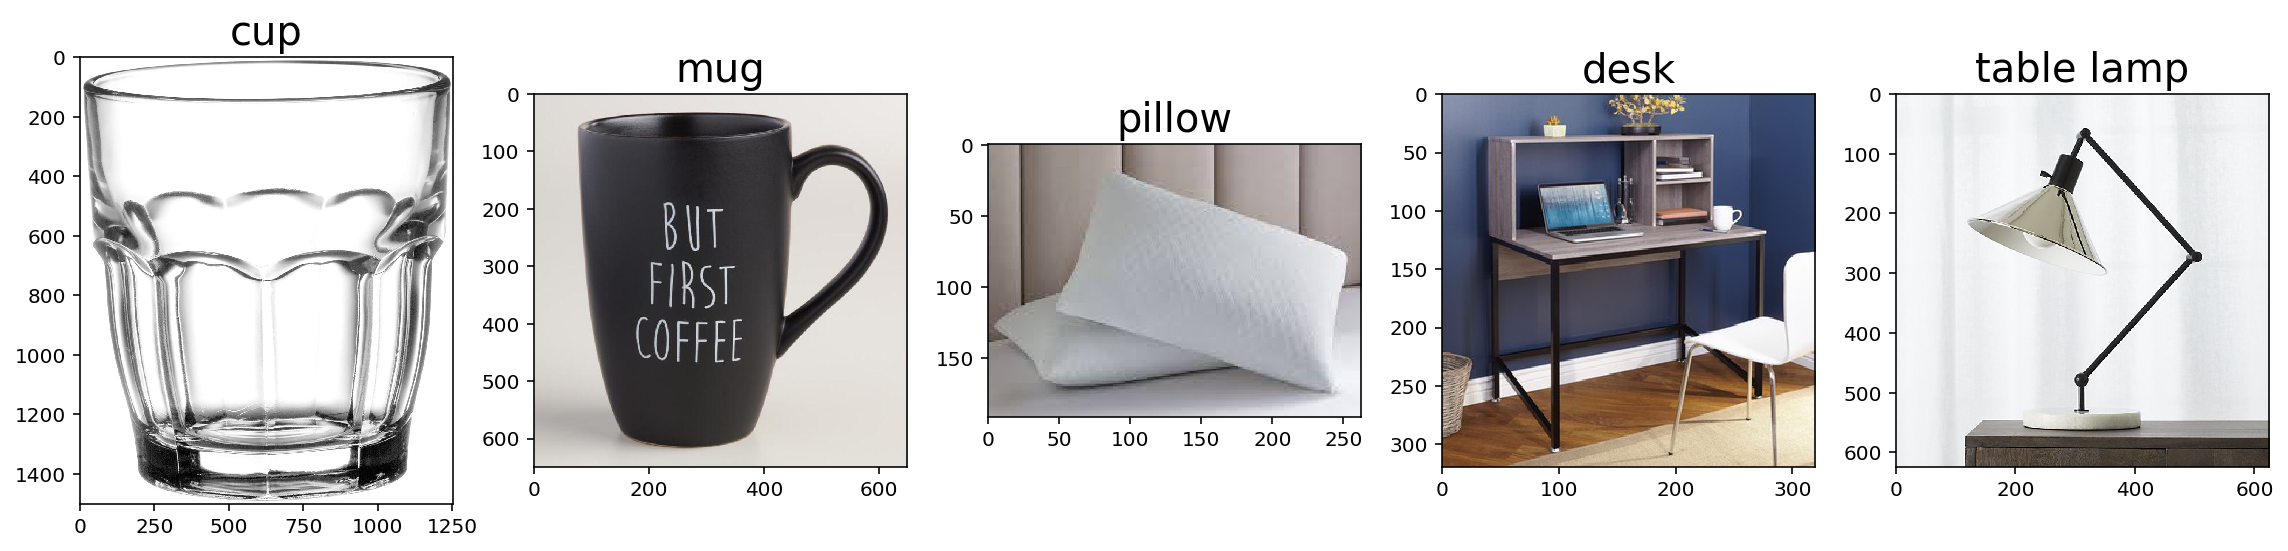

In [16]:
friendly_classifier.classify_from_urls(
    urls, ncols=len(urls)
)